In [1]:
import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('bmh')

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Load data

In [3]:
df = pd.read_csv("training_data.csv")
df.head()

,price,bedrooms,bathrooms,covered_area_m2,total_area_m2,comuna,neighborhood,balcony_area,has_balcony_yn
0,523546,1,1,50,60,Las Condes,Las Condes - Grupo 3,10,1
1,550000,1,1,30,30,Las Condes,Las Condes - Grupo 3,0,0
2,400000,1,1,37,37,Las Condes,Las Condes - Grupo 3,0,0
3,465375,1,1,48,51,Las Condes,Las Condes - Grupo 3,3,1
4,450000,1,1,45,45,Las Condes,Las Condes - Grupo 3,0,0


## Check data

In [4]:
df[['price', 'covered_area_m2', 'total_area_m2']].describe().astype('int')

,price,covered_area_m2,total_area_m2
count,17508,17508,17508
mean,556852,65,71
std,395099,42,47
min,175000,16,16
25%,300000,38,40
50%,420000,50,54
75%,650000,80,85
max,2966763,500,535


In [5]:
df['comuna'] = df['comuna'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17508 entries, 0 to 17507
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   price            17508 non-null  int64   
 1   bedrooms         17508 non-null  int64   
 2   bathrooms        17508 non-null  int64   
 3   covered_area_m2  17508 non-null  int64   
 4   total_area_m2    17508 non-null  int64   
 5   comuna           17508 non-null  category
 6   neighborhood     17508 non-null  category
 7   balcony_area     17508 non-null  int64   
 8   has_balcony_yn   17508 non-null  int64   
dtypes: category(2), int64(7)
memory usage: 995.1 KB


## Train machine learning models

In [7]:
SEED = 21

features_dict = {
    'dataset_01': ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna', 'neighborhood'],
    'dataset_02': ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna', 'neighborhood'],
    'dataset_03': ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'],
    'dataset_04': ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'],
    'dataset_05': ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna', 'neighborhood'],
    'dataset_06': ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna', 'neighborhood']
}

models = {
    'RandomForest': RandomForestRegressor(random_state=SEED, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=SEED, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_seed=SEED, silent=True)
}

In [8]:
NUM_SEEDS = 10
results = []

for dataset_key in features_dict:
    # Define features and target
    features = features_dict[dataset_key]
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
        
    # Train tree-base models
    for model_key in models:     
        estimator = models[model_key]
        
        for num in range(NUM_SEEDS):
            CV = KFold(n_splits=5, shuffle=True, random_state=num)
        
            # Evaluate model using cross validation
            start = time()
            scores = cross_val_score(estimator, 
                                     X, y, 
                                     scoring='neg_median_absolute_error', 
                                     cv=CV, 
                                     n_jobs=-1)
            end = time()
            
            row = []
            row.extend([
                dataset_key, 
                model_key, 
                num, 
                abs(scores.mean()), 
                end - start
            ])
            results.append(row)
        
# Create dataframe with results
df_columns = [
    'dataset', 
    'model', 
    'seed', 
    'avg_score', 
    'training_time'
] 
results_df = pd.DataFrame(results, columns=df_columns)
results_df

,dataset,model,seed,avg_score,training_time
0,dataset_01,RandomForest,0,40341.327405,7.775567
1,dataset_01,RandomForest,1,40248.205500,7.021667
2,dataset_01,RandomForest,2,40137.688354,6.130374
3,dataset_01,RandomForest,3,39903.796466,6.633214
4,dataset_01,RandomForest,4,40462.183956,7.044327
...,...,...,...,...,...
175,dataset_06,CatBoost,5,38290.997265,8.808903
176,dataset_06,CatBoost,6,37864.278722,9.283784
177,dataset_06,CatBoost,7,38266.925576,8.474000
178,dataset_06,CatBoost,8,38415.356282,8.655006


## Analyze results

In [9]:
# Total training time
results_df['training_time'].sum()

1017.9948308467865

In [10]:
# Average score for each model
results_df.groupby('model')['avg_score'].mean().sort_values().astype('int')

model
CatBoost        38595
RandomForest    39356
LightGBM        39580
Name: avg_score, dtype: int32

In [11]:
# Average training time for each model
results_df.groupby('model')['training_time'].mean().sort_values()

model
LightGBM        0.543989
RandomForest    7.523682
CatBoost        8.898909
Name: training_time, dtype: float64

In [12]:
# Average score for each model and dataset combination
results_df.groupby(['model', 'dataset'])['avg_score'].mean().sort_values().astype('int')

model         dataset   
CatBoost      dataset_05    38121
              dataset_06    38240
              dataset_04    38341
              dataset_02    38496
RandomForest  dataset_05    38762
              dataset_06    38797
CatBoost      dataset_03    38897
LightGBM      dataset_06    39266
              dataset_04    39301
RandomForest  dataset_04    39368
LightGBM      dataset_02    39369
              dataset_05    39391
RandomForest  dataset_02    39409
CatBoost      dataset_01    39476
RandomForest  dataset_03    39588
LightGBM      dataset_03    39817
RandomForest  dataset_01    40211
LightGBM      dataset_01    40336
Name: avg_score, dtype: int32

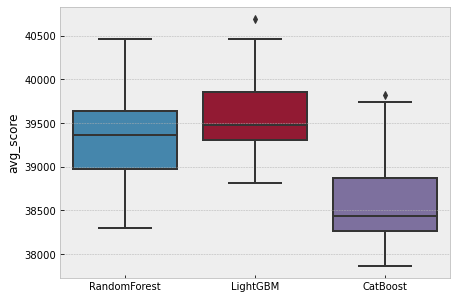

In [13]:
plt.figure(figsize=(7,5))
sb.boxplot(x='model', y='avg_score', data=results_df)
plt.xlabel("")
plt.show()

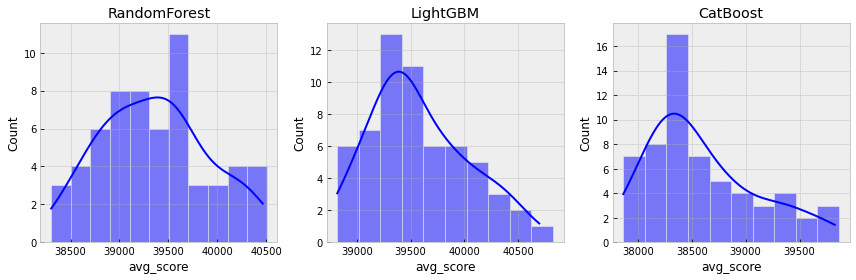

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, model in zip(axes.flatten(), models.keys()):
    data = results_df[results_df['model']==model]
    sb.histplot(data=data['avg_score'], kde=True, ax=ax, binwidth=200)
    ax.set_title(model)
    
    fig.tight_layout()

### Analyze results by dataset for CatBoost

In [15]:
catboost_results_df = results_df[results_df['model']=='CatBoost']

In [16]:
avg_score_by_dataset = catboost_results_df.groupby('dataset')['avg_score'].mean().sort_values()
avg_score_by_dataset

dataset
dataset_05    38121.587280
dataset_06    38240.287676
dataset_04    38341.525954
dataset_02    38496.374746
dataset_03    38897.376184
dataset_01    39476.413391
Name: avg_score, dtype: float64

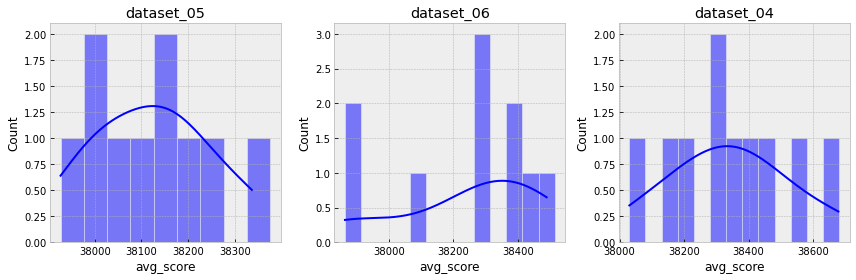

In [17]:
sorted_datasets = avg_score_by_dataset.index.tolist()
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, dataset in zip(axes.flatten(), sorted_datasets[:3]):
    data = catboost_results_df[
        (catboost_results_df['dataset']==dataset)
    ]
    sb.histplot(data=data['avg_score'], kde=True, ax=ax, binwidth=50)
    ax.set_title(dataset)
    
    fig.tight_layout()